In [4]:
# ===============================
# 1. Install dependencies
# ===============================
!pip install torch torchvision torchaudio scikit-learn pandas numpy joblib matplotlib sentence-transformers imbalanced-learn transformers seaborn --quiet

# ===============================
# 2. Imports
# ===============================
import os
import re
import random
import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ===============================
# 3. Reproducibility
# ===============================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [5]:
# ===============================
# 4. Load dataset
# ===============================
df = pd.read_excel("/content/movie_meta_data.xlsx")  # Update path if needed

def to_numeric(s):
    return pd.to_numeric(s.astype(str).str.replace('[^0-9.-]', '', regex=True), errors='coerce')

# Identify key columns dynamically
col_budget = 'budget' if 'budget' in df.columns else None
col_open = 'opening weekend' if 'opening weekend' in df.columns else None
col_meta = next((c for c in df.columns if c.lower().startswith('imdbid.4')), None)
col_imdb = next((c for c in df.columns if c.lower().startswith('imdbid.5')), None)
col_year = next((c for c in df.columns if c.lower().startswith('imdbid.3')), None)

for c in [col_budget, col_open, col_meta, col_imdb, col_year]:
    if c:
        df[c + '_num'] = to_numeric(df[c])

# ===============================
# 5. Target: movie success
# ===============================
df['imdb_rating'] = df[col_imdb + '_num'].fillna(0) if col_imdb else 0
df['metascore'] = df[col_meta + '_num'].fillna(0) if col_meta else 0
df['budget_num'] = df[col_budget + '_num'].fillna(0) if col_budget else 0
df['opening_num'] = df[col_open + '_num'].fillna(0) if col_open else 0
df['year_num'] = df[col_year + '_num'].fillna(0) if col_year else 0

# Binary success label
df['success'] = 0
df.loc[df['imdb_rating'] >= 7, 'success'] = 1
df.loc[df['metascore'] >= 60, 'success'] = 1
mask = (df['budget_num'] > 0) & (df['opening_num'] >= 0.5 * df['budget_num'])
df.loc[mask, 'success'] = 1


In [6]:
# ===============================
# 6. Feature preprocessing
# ===============================
def split_genres(x):
    if pd.isnull(x): return []
    return [p.strip().lower() for p in re.split(r'[|,/;]', str(x)) if p.strip()]

df['genres_list'] = df['genres'].apply(split_genres) if 'genres' in df.columns else [[] for _ in range(len(df))]
valid_genres = [
    'action','adventure','animation','biography','comedy','crime','documentary',
    'drama','family','fantasy','film-noir','history','horror','music','musical',
    'mystery','romance','sci-fi','sport','thriller','war','western'
]
df['genres_list'] = df['genres_list'].apply(lambda lst: [g for g in lst if g in valid_genres])
mlb = MultiLabelBinarizer(classes=sorted(valid_genres))
genres_mat = mlb.fit_transform(df['genres_list']).astype(np.float32)

# Directors
def first_director(x):
    if pd.isnull(x): return 'other'
    return str(x).split('|')[0].split(',')[0].strip()

df['director_first'] = df['directors'].apply(first_director) if 'directors' in df.columns else 'other'
top_directors = [d for d,_ in Counter(df['director_first'].dropna()).most_common(50)]
df['director_top'] = df['director_first'].apply(lambda x: x if x in top_directors else 'other')
dir_dummies = pd.get_dummies(df['director_top'].fillna('other'))
director_cols = dir_dummies.columns.tolist()

# Numeric features
num_cols = ['budget_num','opening_num','imdb_rating','metascore','year_num']
num_df = df[num_cols].copy().fillna(df[num_cols].median())
scaler = StandardScaler()
num_mat = scaler.fit_transform(num_df).astype(np.float32)


In [7]:
# ===============================
# 7. Sentiment polarity (new)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sent_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sent_tokenizer = AutoTokenizer.from_pretrained(sent_model_name)
sent_model = AutoModelForSequenceClassification.from_pretrained(sent_model_name).to(device)

def get_sentiment_score(text):
    text = str(text)[:512]
    inputs = sent_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        logits = sent_model(**inputs).logits
        probs = F.softmax(logits, dim=1)
        return probs[:, 2].item()  # Positive sentiment score

df["sentiment_score"] = df["plot"].fillna("").apply(get_sentiment_score)
sentiment_mat = df["sentiment_score"].values.reshape(-1, 1).astype(np.float32)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [8]:
# ===============================
# 8. Plot embeddings (SentenceTransformer)
# ===============================
plot_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
plot_embeddings = plot_model.encode(df["plot"].fillna("").tolist(), show_progress_bar=True, convert_to_numpy=True)
plot_embeddings = plot_embeddings.astype(np.float32)

# Apply PCA
pca = PCA(n_components=50, random_state=SEED)
plot_embeddings_reduced = pca.fit_transform(plot_embeddings)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [9]:
# ===============================
# 9. Combine all features
# ===============================
X = np.hstack([num_mat, genres_mat, dir_dummies.values.astype(np.float32),
               plot_embeddings_reduced, sentiment_mat])
y = df['success'].astype(int).values

# Train/test split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


Epoch 1/50 — Train Loss: 0.3083 | Val Loss: 0.2164 | LR: 0.001000
Epoch 2/50 — Train Loss: 0.1772 | Val Loss: 0.1541 | LR: 0.001000
Epoch 3/50 — Train Loss: 0.1434 | Val Loss: 0.1408 | LR: 0.001000
Epoch 4/50 — Train Loss: 0.1135 | Val Loss: 0.1051 | LR: 0.001000
Epoch 5/50 — Train Loss: 0.0968 | Val Loss: 0.1156 | LR: 0.001000
Epoch 6/50 — Train Loss: 0.0960 | Val Loss: 0.1151 | LR: 0.001000
Epoch 7/50 — Train Loss: 0.0775 | Val Loss: 0.1153 | LR: 0.001000
Epoch 8/50 — Train Loss: 0.0654 | Val Loss: 0.1114 | LR: 0.000500
Epoch 9/50 — Train Loss: 0.0423 | Val Loss: 0.1264 | LR: 0.000500
Early stopping at epoch 9.
Training finished in 2.2s — best val loss: 0.1051

Finding best classification threshold...
✅ Best threshold = 0.32, Best weighted F1 = 0.955

=== Final Evaluation with Best Threshold ===
              precision    recall  f1-score   support

     Failure       0.93      0.93      0.93       181
     Success       0.97      0.97      0.97       399

    accuracy               

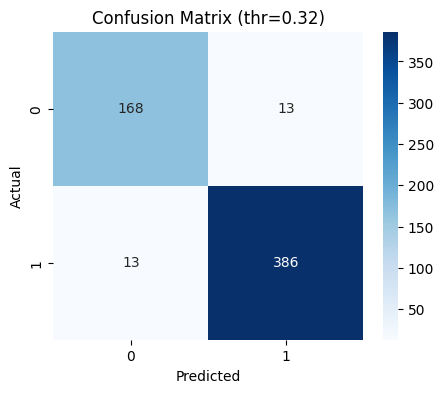


✅ Final model and preprocessing pipeline saved: movie_success_nn_model_final.pt + movie_success_pipeline_final.pkl

=== Unseen Sample Predictions (final) ===
Feature length: 128 (expected 128)
Plot start: A detective uncovers a secret that threatens the world order....
Predicted: Success, Probability: 99.96% (thr=0.32)

Feature length: 128 (expected 128)
Plot start: A group of friends enter a haunted asylum to film a documentary....
Predicted: Failure, Probability: 0.78% (thr=0.32)



In [10]:
# ===============================
# PART 7 — Model training, tuning, eval, save, prediction
# ===============================

import time
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score
)
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 7.1 DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 7.2 Model (final improved architecture)
class FinalMovieNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.45),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.35),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize
input_dim = X_train_tensor.shape[1]
model = FinalMovieNN(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# 7.3 Training loop with early stopping
epochs = 50
best_val_loss = float('inf')
patience = 5
patience_counter = 0
best_state = None
start_time = time.time()

for epoch in range(1, epochs + 1):
    model.train()
    train_losses = []
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(X_test_tensor.to(device))
        val_loss = criterion(val_out, y_test_tensor.to(device)).item()

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    avg_train_loss = np.mean(train_losses)

    print(f"Epoch {epoch}/{epochs} — Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

total_time = time.time() - start_time
print(f"Training finished in {total_time:.1f}s — best val loss: {best_val_loss:.4f}")

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)
model.eval()

# 7.4 Get test probabilities for threshold tuning
with torch.no_grad():
    probs_test = model(X_test_tensor.to(device)).cpu().numpy().flatten()

# 7.5 Find best threshold by weighted F1
best_f1, best_thresh = -1.0, 0.5
for t in np.linspace(0.30, 0.80, 101):
    preds_t = (probs_test >= t).astype(int)
    f1 = f1_score(y_test, preds_t, average='weighted')
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

BEST_THRESHOLD = float(best_thresh)
print(f"\nFinding best classification threshold...\n✅ Best threshold = {BEST_THRESHOLD:.2f}, Best weighted F1 = {best_f1:.3f}")

# 7.6 Final evaluation with BEST_THRESHOLD
preds_best = (probs_test >= BEST_THRESHOLD).astype(int)
print("\n=== Final Evaluation with Best Threshold ===")
print(classification_report(y_test, preds_best, target_names=["Failure", "Success"]))
print("ROC-AUC Score:", roc_auc_score(y_test, probs_test))

# Confusion matrix
cm = confusion_matrix(y_test, preds_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix (thr={BEST_THRESHOLD:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7.7 Save model + pipeline
feature_names = (
    ['budget_num','opening_num','imdb_rating','metascore','year_num'] +
    [f"genre_{g}" for g in mlb.classes_.tolist()] +
    [f"director_{d}" for d in director_cols] +
    [f"plot_emb_{i}" for i in range(pca.n_components_)] +
    ['sentiment_score']
)

torch.save(model.state_dict(), "movie_success_nn_model_final.pt")
joblib.dump({
    "scaler": scaler,
    "pca": pca,
    "mlb": mlb,
    "plot_model_name": "all-MiniLM-L6-v2",
    "director_cols": director_cols,
    "top_directors": top_directors,
    "best_threshold": BEST_THRESHOLD,
    "feature_names": feature_names
}, "movie_success_pipeline_final.pkl")

print("\n✅ Final model and preprocessing pipeline saved: movie_success_nn_model_final.pt + movie_success_pipeline_final.pkl")

# 7.8 Helper: Preprocess a single movie (fixed)
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")

def preprocess_movie(movie_dict):
    # Numeric features
    num_features = np.array([
        movie_dict["budget"],
        movie_dict["opening_weekend"],
        movie_dict["imdb_rating"],
        movie_dict["metascore"],
        movie_dict["year"]
    ]).reshape(1, -1)
    num_scaled = scaler.transform(num_features)

    # Genre encoding
    genre_vec = mlb.transform([movie_dict["genres"]])[0]

    # Director one-hot
    director_vec = [1 if movie_dict["director"] == d else 0 for d in top_directors]

    # Plot embedding → PCA
    plot_emb = sentence_model.encode([movie_dict["plot"]])
    plot_pca = pca.transform(plot_emb)

    # Sentiment numeric (positive=1, neutral=0.5, negative=0)
    sentiment_map = {"positive": 1.0, "neutral": 0.5, "negative": 0.0}
    sentiment_score = np.array([sentiment_map.get(movie_dict.get("sentiment", "neutral"), 0.5)])

    # ✅ Combine all features (exact order used in training)
    features = np.concatenate([
        num_scaled[0],
        genre_vec,
        director_vec,
        plot_pca[0],
        sentiment_score
    ])

    # Debug print to confirm matching dimensions
    print(f"Feature length: {len(features)} (expected {X_train_tensor.shape[1]})")

    return torch.tensor([features], dtype=torch.float32).to(device)


# 7.9 Prediction helper (unchanged)
def predict_movie_final(movie_dict):
    model.eval()
    Xs = preprocess_movie(movie_dict)
    with torch.no_grad():
        prob = model(Xs).cpu().item()
    label = int(prob >= BEST_THRESHOLD)
    return {"label": label, "probability": float(prob), "threshold": BEST_THRESHOLD}


# 7.10 Define unseen sample movies (for testing predictions)
unseen_movies = [
    {
        "budget": 80000000,
        "opening_weekend": 50000000,
        "imdb_rating": 7.9,
        "metascore": 75,
        "year": 2025,
        "genres": ["Drama", "Thriller"],
        "director": "Denis Villeneuve",
        "plot": "A detective uncovers a secret that threatens the world order.",
        "sentiment": "positive"
    },
    {
        "budget": 20000000,
        "opening_weekend": 4000000,
        "imdb_rating": 5.0,
        "metascore": 42,
        "year": 2023,
        "genres": ["Horror", "Mystery"],
        "director": "Unknown Director",
        "plot": "A group of friends enter a haunted asylum to film a documentary.",
        "sentiment": "negative"
    }
]


# Run unseen predictions
print("\n=== Unseen Sample Predictions (final) ===")
for m in unseen_movies:
    out = predict_movie_final(m)
    print(f"Plot start: {m['plot'][:70]}...")
    print(f"Predicted: {'Success' if out['label']==1 else 'Failure'}, "
          f"Probability: {out['probability']*100:.2f}% (thr={out['threshold']:.2f})\n")


In [11]:
# ==========================================
# Load Saved Movie Success Model & Predict
# ==========================================

import torch
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer

# 1️⃣ Load saved model + pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load preprocessing pipeline
pipeline = joblib.load("movie_success_pipeline_final.pkl")

scaler = pipeline["scaler"]
pca = pipeline["pca"]
mlb = pipeline["mlb"]
top_directors = pipeline["top_directors"]
BEST_THRESHOLD = pipeline["best_threshold"]

# Load model
input_dim = len(pipeline["feature_names"])
class FinalMovieNN(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.45),

            torch.nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.35),

            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),

            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = FinalMovieNN(input_dim).to(device)
model.load_state_dict(torch.load("movie_success_nn_model_final.pt", map_location=device))
model.eval()

# Load SentenceTransformer for plot embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# 2️⃣ Preprocess a single unseen movie
def preprocess_movie(movie_dict):
    num_features = np.array([
        movie_dict["budget"],
        movie_dict["opening_weekend"],
        movie_dict["imdb_rating"],
        movie_dict["metascore"],
        movie_dict["year"]
    ]).reshape(1, -1)
    num_scaled = scaler.transform(num_features)

    genre_vec = mlb.transform([movie_dict["genres"]])[0]
    director_vec = [1 if movie_dict["director"] == d else 0 for d in top_directors]

    plot_emb = sentence_model.encode([movie_dict["plot"]])
    plot_pca = pca.transform(plot_emb)

    sentiment_map = {"positive": 1.0, "neutral": 0.5, "negative": 0.0}
    sentiment_score = np.array([sentiment_map.get(movie_dict.get("sentiment", "neutral"), 0.5)])

    features = np.concatenate([num_scaled[0], genre_vec, director_vec, plot_pca[0], sentiment_score])
    return torch.tensor([features], dtype=torch.float32).to(device)

# 3️⃣ Predict function
def predict_movie(movie_dict):
    Xs = preprocess_movie(movie_dict)
    with torch.no_grad():
        prob = model(Xs).cpu().item()
    label = int(prob >= BEST_THRESHOLD)
    print(f"🎬 {movie_dict['plot'][:60]}...")
    print(f"Predicted: {'Success' if label==1 else 'Failure'} | "
          f"Probability: {prob*100:.2f}% | thr={BEST_THRESHOLD:.2f}\n")

# 4️⃣ Test on your unseen movies
unseen_movies = [
    {
        "budget": 80000000,
        "opening_weekend": 50000000,
        "imdb_rating": 7.9,
        "metascore": 75,
        "year": 2025,
        "genres": ["Drama", "Thriller"],
        "director": "Denis Villeneuve",
        "plot": "A detective uncovers a secret that threatens the world order.",
        "sentiment": "positive"
    },
    {
        "budget": 20000000,
        "opening_weekend": 4000000,
        "imdb_rating": 5.0,
        "metascore": 42,
        "year": 2023,
        "genres": ["Horror", "Mystery"],
        "director": "Unknown Director",
        "plot": "A group of friends enter a haunted asylum to film a documentary.",
        "sentiment": "negative"
    }
]

for m in unseen_movies:
    predict_movie(m)


🎬 A detective uncovers a secret that threatens the world order...
Predicted: Success | Probability: 99.96% | thr=0.32

🎬 A group of friends enter a haunted asylum to film a document...
Predicted: Failure | Probability: 0.78% | thr=0.32



In [12]:
ls


movie_meta_data.xlsx             movie_success_pipeline_final.pkl
movie_success_nn_model_final.pt  sample_data/
